## Packages Used 
* Pandas
* Numpy
* SciKit Learn
* Matplot Lib
* Seaborn

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# TODO replace sns with matplot
from matplotlib import pyplot
import seaborn as sns

## Loading data from CSV to Pandas DataFrame

In [34]:
data = pd.read_csv("DataSet_PCP_Change.csv")

## Statistical Information from raw data

In [35]:
data.groupby(by='outcome', as_index=False).agg({'testindex': pd.Series.nunique})

,outcome,testindex
0,0,3003
1,1,127


Little over 4% people opts to change their PCP

In [36]:
data.outcome.value_counts(normalize=True) * 100

0    95.942492
1     4.057508
Name: outcome, dtype: float64

## Feature Enrichement

Binning for feature `distance` is required as the boxplot clearly shows that mostly distance is in range 0 to 5. 
Raw values of feature `distance` will lead to inaccurate predictions

In [5]:
# Remove rows with missing target, separate target from predictors
data.dropna(axis=0, subset=['outcome'], inplace=True)
y = data.outcome
data.drop(['outcome'], axis=1, inplace=True)

In [6]:
# replace all NaN with 0 from the claims_daysaway column dataset
data = data.fillna(0)

Binning for feature `distance` is required as the boxplot clearly shows that mostly distance is in range 0 to 5. 
Raw values of feature `distance` will lead to inaccurate predictions

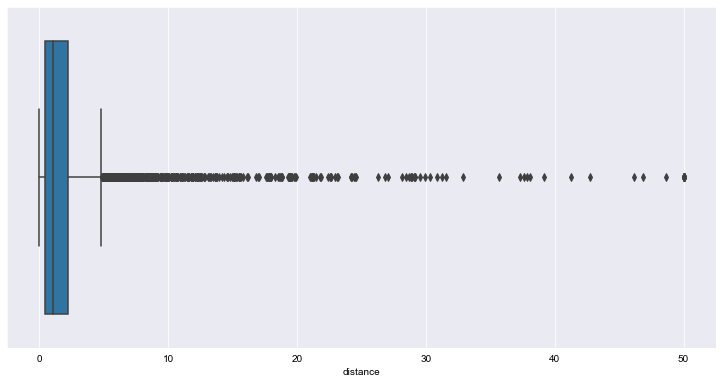

In [7]:
custom_style = {'axes.labelcolor': 'black',
                'xtick.color': 'black',
                'ytick.color': 'black'}
sns.set_style("darkgrid", rc=custom_style)

a4_dims = (12.7, 6.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.boxplot(x=data.distance)

In [8]:
# zone_labels = ["zone1", "zone2", "zone3", "zone4"]
zone_labels = ["1", "2", "3", "4"]
data['distance_bin'] = pd.cut(data['distance'], bins=[0, 2, 5, 10, 60], labels=zone_labels, include_lowest=True)
# categories = np.array(zone_labels)
# data['distance_bin'] = pd.Categorical(data['distance_bin'], categories=categories, ordered=True)

data.drop(['distance'], axis=1, inplace=True)

# convert dtype for `distance_bin` from category to float
data["distance_bin"] = data.distance_bin.astype(float)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3130 entries, 0 to 3129
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   testindex          3130 non-null   int64  
 1   visit_count        3130 non-null   int64  
 2   claims_daysaway    3130 non-null   float64
 3   tier               3130 non-null   float64
 4   fqhc               3130 non-null   int64  
 5   pcp_lookback       3130 non-null   int64  
 6   family_assignment  3130 non-null   int64  
 7   kid                3130 non-null   int64  
 8   is_ped             3130 non-null   int64  
 9   same_gender        3130 non-null   int64  
 10  same_language      3130 non-null   int64  
 11  same_address       3130 non-null   int64  
 12  distance_bin       3130 non-null   float64
dtypes: float64(3), int64(10)
memory usage: 342.3 KB


In [10]:
data.describe()

,testindex,visit_count,claims_daysaway,tier,fqhc,pcp_lookback,family_assignment,kid,is_ped,same_gender,same_language,same_address,distance_bin
count,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000,3130.000000
mean,2519.981789,1.074121,24.039617,1.809585,0.192332,0.442173,0.341853,0.376997,0.392332,0.511821,0.064856,0.065495,1.473482
std,1439.130702,3.160802,72.747243,0.995116,0.394196,0.496724,0.474406,0.484712,0.488348,0.499940,0.246311,0.247437,0.883118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1271.250000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2520.500000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3769.750000,0.000000,0.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000
max,5000.000000,36.000000,736.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


## Histogram to visualize all the possible features and the spread of their values.

array([[<AxesSubplot:title={'center':'testindex'}>,
        <AxesSubplot:title={'center':'visit_count'}>,
        <AxesSubplot:title={'center':'claims_daysaway'}>,
        <AxesSubplot:title={'center':'tier'}>],
       [<AxesSubplot:title={'center':'fqhc'}>,
        <AxesSubplot:title={'center':'pcp_lookback'}>,
        <AxesSubplot:title={'center':'family_assignment'}>,
        <AxesSubplot:title={'center':'kid'}>],
       [<AxesSubplot:title={'center':'is_ped'}>,
        <AxesSubplot:title={'center':'same_gender'}>,
        <AxesSubplot:title={'center':'same_language'}>,
        <AxesSubplot:title={'center':'same_address'}>],
       [<AxesSubplot:title={'center':'distance_bin'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

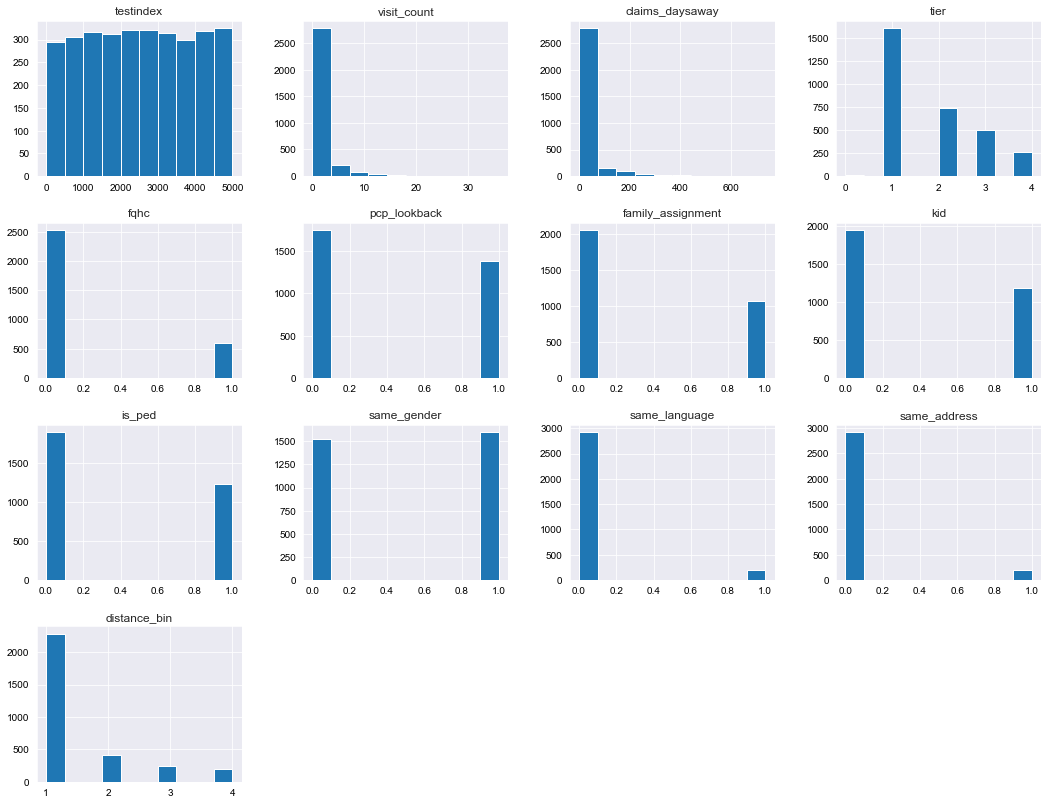

In [11]:

data.hist(figsize=(18,14))

In [12]:
print(data.shape, y.shape)
print(data.columns)

(3130, 13) (3130,)
Index(['testindex', 'visit_count', 'claims_daysaway', 'tier', 'fqhc',
       'pcp_lookback', 'family_assignment', 'kid', 'is_ped', 'same_gender',
       'same_language', 'same_address', 'distance_bin'],
      dtype='object')


## Split the data in Training and Testing dataset using `train_test_split` method from sklearn.

In [13]:
# Break-off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(data, y, train_size=0.7, test_size=0.3, random_state=0)

In [14]:
features = ['visit_count', 'claims_daysaway', 'tier', 'fqhc', 'pcp_lookback', 'family_assignment', 'kid', 'is_ped', 'same_gender', 'same_language', 'same_address', 'distance_bin']

# Models and Predictions

## Classification using RandomForest

In [15]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

print(f"MAE: {mean_absolute_error(y_valid, preds)}")

MAE: 0.07126436415423222


## Classification using Logistic Regression

In [16]:
model = LogisticRegression()
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

print(f"MAE: {mean_absolute_error(y_valid, preds)}")
print(f"Accuracy Score: {accuracy_score(y_valid, preds)}")

MAE: 0.038338658146964855
Accuracy Score: 0.9616613418530351


/opt/miniconda3/envs/bits-py-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Classification using Decision Trees
default splitting critirea is based on gini

In [29]:
model = DecisionTreeClassifier(criterion='gini', random_state=1, max_depth=5)
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

print(f"MAE: {mean_absolute_error(y_valid, preds)}")
print(f"Accuracy Score: {accuracy_score(y_valid, preds)}")

MAE: 0.03727369542066028
Accuracy Score: 0.9627263045793397


In [32]:
model = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=5)
model.fit(X_train[features], y_train)
preds = model.predict(X_valid[features])

print(f"MAE: {mean_absolute_error(y_valid, preds) * 100}")
print(f"Accuracy Score: {accuracy_score(y_valid, preds) * 100}")

MAE: 3.727369542066028
Accuracy Score: 96.27263045793397
